In [81]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [82]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


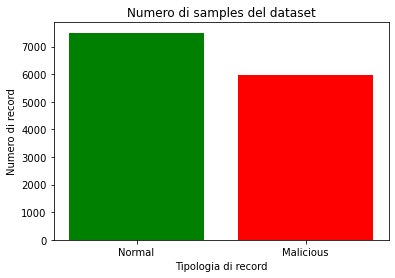

In [83]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [84]:
def preprocessing(data):
    for column in data.columns:
        if data[column].dtype == type(object):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])

In [85]:
#Converto tutti gli altri tipi di attacco in anomaly in modo da avere solo o normal o anomaly
def conversione(df):
    datacpy = df.copy()
    for i in range(len(datacpy.result)):
        if(datacpy.result.loc[i] != 'normal'):
            datacpy.result.loc[i] = 'anomaly'
    return datacpy

df_data_confronti = data.copy()
df_data = conversione(data)

C:\Users\39331\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
data_with_label = df_data.copy()

seed = 5392

#dati di train e test per calcolare FP/FN etc.
y1 = df_data_confronti.result
y_train_confronti, y_test_confronti = splitter(y1, test_size=0.3, random_state=seed)
print("y_test_confronti: ")
print(y_test_confronti)

#dati per il train e il test
preprocessing(df_data)

y = df_data.result
x = df_data.drop("result", axis=1)

profile = cProfile.Profile()
x_train, x_test, y_train, y_test = splitter(x, y, test_size=0.3, random_state=seed)
print('y_test: ')
print(y_test)

y_test_confronti: 
5442    normal
8755       dos
5352    normal
400     normal
5772    normal
         ...  
5036     probe
8286     probe
2264    normal
5819    normal
7417       dos
Name: result, Length: 4036, dtype: object
y_test: 
5442    1
8755    0
5352    1
400     1
5772    1
       ..
5036    0
8286    0
2264    1
5819    1
7417    0
Name: result, Length: 4036, dtype: int32


In [87]:
num_train = len(x_train)
num_train_normal = 0

print("Il dataset per il train è composto da : ",num_train,"record")

for i in y_train_confronti:
    if(i == 'normal'):
        num_train_normal = num_train_normal + 1
        
num_train_anomaly = num_train - num_train_normal

print("Il dataset per il train è composto da : ",num_train_anomaly,"anomalie")
print("Il dataset per il train è composto da : ",num_train_normal,"record normali")

Il dataset per il train è composto da :  9415 record
Il dataset per il train è composto da :  4143 anomalie
Il dataset per il train è composto da :  5272 record normali


In [88]:
num_test = len(x_test)
num_test_normal = 0
num_test_dos = 0
num_test_r2l = 0
num_test_probe = 0
num_test_u2r = 0

print("Il dataset per il test è composto da : ",num_test,"record (sia normali che anomali)")
print("")

for i in y_test_confronti:
    if(i == 'normal'):
        num_test_normal = num_test_normal + 1
    if(i == 'dos'):
        num_test_dos = num_test_dos + 1
    if(i == 'r2l'):
        num_test_r2l = num_test_r2l + 1
    if(i == 'u2r'):
        num_test_u2r = num_test_u2r + 1
    if(i == 'probe'):
        num_test_probe = num_test_probe + 1

num_test_anomaly = num_test - num_test_normal

print("Il dataset per il test è composto da",num_test_anomaly,"anomalie di cui :")
print("i)",num_test_dos, "record Dos")
print("ii)",num_test_r2l, "record R2L")
print("iii)",num_test_u2r, "record U2R")
print("iv)",num_test_probe, "record Probe")
print("")
print("Il dataset per il test è composto da",num_test_normal,"record normali")

Il dataset per il test è composto da :  4036 record (sia normali che anomali)

Il dataset per il test è composto da 1808 anomalie di cui :
i) 1525 record Dos
ii) 104 record R2L
iii) 20 record U2R
iv) 159 record Probe

Il dataset per il test è composto da 2228 record normali


In [89]:
profile.enable()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
val_indices = 200
x_val = x_train[-val_indices:]
y_val = y_train[-val_indices:]

In [90]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              22528     
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)             

In [91]:
model.fit(x_train, y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/15
19/19 [==============================] - 5s 262ms/step - loss: 7.4464 - accuracy: 0.5372 - val_loss: 4.4490 - val_accuracy: 0.7650
Epoch 2/15
19/19 [==============================] - 4s 233ms/step - loss: 4.0461 - accuracy: 0.6309 - val_loss: 3.8996 - val_accuracy: 0.6500
Epoch 3/15
19/19 [==============================] - 4s 225ms/step - loss: 3.1081 - accuracy: 0.7142 - val_loss: 2.4752 - val_accuracy: 0.7300
Epoch 4/15
19/19 [==============================] - 4s 225ms/step - loss: 2.3482 - accuracy: 0.8195 - val_loss: 1.9610 - val_accuracy: 0.9300
Epoch 5/15
19/19 [==============================] - 4s 223ms/step - loss: 1.6074 - accuracy: 0.9288 - val_loss: 1.3721 - val_accuracy: 0.8450
Epoch 6/15
19/19 [==============================] - 5s 243ms/step - loss: 1.0361 - accuracy: 0.9426 - val_loss: 0.8606 - val_accuracy: 0.9350
Epoch 7/15
19/19 [==============================] - 4s 225ms/step - loss: 0.6993 - accuracy: 0.9426 - val_loss: 0.5099 - val_accuracy: 0.9500
Epoch 

In [92]:
y_pred = model.predict(x_test)
profile.disable()
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
profile.dump_stats('output.prof')
stream = open('result/keras_kdd_profiling_binary.txt', 'w')
stats = pstats.Stats('output.prof', stream=stream)
stats.sort_stats('cumtime')
stats.print_stats()
os.remove('output.prof')

Il numero di anomalie rilevate dal classificatore è : 1808 di cui 1765 Corrette (TN), 43 scambiate per normali (FP), 19 record normali classificati come anomalie (FN), infine ho 2209 record normali classificati come normali (TP)

Ho classificato come anomalie: 
155 Probe (TN) --> 97.48427672955975 %
92 R2L (TN) --> 88.46153846153845 %
14 U2R (TN) --> 70.0 %
1504 Dos (TN) --> 98.62295081967213 %
19 Normali (FN) --> 0.8527827648114902 %

Ho classificato come record normali: 
4 Probe (FP)
12 R2L (FP)
6 U2R (FP)
21 Dos (FP)
2209 Normali (TP) --> 99.1472172351885 %


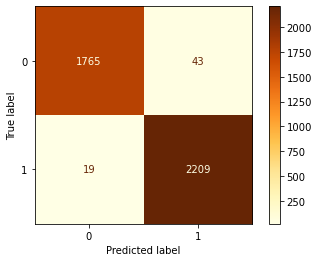

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1808
           1       0.98      0.99      0.99      2228

    accuracy                           0.98      4036
   macro avg       0.99      0.98      0.98      4036
weighted avg       0.98      0.98      0.98      4036



In [99]:
conf_matrix = confusion_matrix(y_test, y_pred)

count = 0 #contatore per il for

y_test_confronti = y_test_confronti.reset_index(drop=True) #resetto gli indici facendoli ripartire da 0
normal_to_anomaly = 0
num_probe_classificate = 0
num_r2l_classificate = 0
num_u2r_classificate = 0
num_dos_classificate = 0
normal_to_normal = 0
num_probe_to_normal = 0
num_r2l_to_normal = 0
num_u2r_to_normal = 0
num_dos_to_normal = 0

for i in y_pred:
    if(i == 0): #il classificatore ha predetto una anomalia
        if(y_test_confronti[count] == "normal"): #ho classificato una anomalia ma era un record normale
            normal_to_anomaly = normal_to_anomaly + 1
        if(y_test_confronti[count] == "probe"): #ho classificato una anomalia di tipo probe
            num_probe_classificate = num_probe_classificate + 1
        if(y_test_confronti[count] == "r2l"): #ho classificato una anomalia di tipo r2l
            num_r2l_classificate = num_r2l_classificate + 1
        if(y_test_confronti[count] == "u2r"): #ho classificato una anomalia di tipo u2r
            num_u2r_classificate = num_u2r_classificate + 1
        if(y_test_confronti[count] == "dos"): #ho classificato una anomalia di tipo dos
            num_dos_classificate = num_dos_classificate + 1
    if(i == 1): #il classificatore ha predetto un record normale
        if(y_test_confronti[count] == "normal"): #ho classificato un record normale e lo era
            normal_to_normal = normal_to_normal + 1
        if(y_test_confronti[count] == "probe"): #ho classificato un record normale e era di tipo probe
            num_probe_to_normal = num_probe_to_normal + 1
        if(y_test_confronti[count] == "r2l"): #ho classificato un record normale e era di tipo r2l
            num_r2l_to_normal = num_r2l_to_normal + 1
        if(y_test_confronti[count] == "u2r"): #ho classificato un record normale e era di tipo u2r
            num_u2r_to_normal = num_u2r_to_normal + 1
        if(y_test_confronti[count] == "dos"): #ho classificato un record normale e era di tipo dos
            num_dos_to_normal = num_dos_to_normal + 1
    count=count +1

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp = disp.plot(cmap='YlOrBr')

anomalie_rilevate = conf_matrix[0][0]+conf_matrix[0][1]

print("Il numero di anomalie rilevate dal classificatore è :",anomalie_rilevate,
     "di cui",conf_matrix[0][0], "Corrette (TN),", 
     conf_matrix[0][1], "scambiate per normali (FP),",
     conf_matrix[1][0], "record normali classificati come anomalie (FN),",
     "infine ho", conf_matrix[1][1], "record normali classificati come normali (TP)")
print("")

print("Ho classificato come anomalie: ")
print(num_probe_classificate, "Probe (TN) -->", (num_probe_classificate/num_test_probe)*100,"%")
print(num_r2l_classificate, "R2L (TN) -->", (num_r2l_classificate/num_test_r2l)*100,"%")
print(num_u2r_classificate, "U2R (TN) -->", (num_u2r_classificate/num_test_u2r)*100,"%")
print(num_dos_classificate, "Dos (TN) -->", (num_dos_classificate/num_test_dos)*100,"%")
print(normal_to_anomaly, "Normali (FN) -->", (normal_to_anomaly/num_test_normal)*100,"%")

print("")

print("Ho classificato come record normali: ")
print(num_probe_to_normal, "Probe (FP)")
print(num_r2l_to_normal, "R2L (FP)")
print(num_u2r_to_normal, "U2R (FP)")
print(num_dos_to_normal, "Dos (FP)")
print(normal_to_normal, "Normali (TP) -->", (normal_to_normal/num_test_normal)*100,"%")

plt.show()
print(classification_report(y_test, y_pred))